# Predicting Academic Paper Citation Impact from Peer Review Data


Group member:

- Yixi Zhou
- Yifan Huang
- Qianyi Gong
    

## 1. Introduction

### 1.1 Project Overview

This project explores the relationship between peer review evaluations and the long-term citation impact of academic papers. By analyzing reviewer comments, evaluation scores, and paper metadata, we aim to identify early indicators of scientific influence that emerge during the peer review process. Understanding these relationships could provide valuable insights for editorial decisions and improve our understanding of what constitutes impactful research.

### 1.2 Problem Statement

While peer review plays a crucial role in scientific publishing, its predictive power for long-term academic impact remains understudied. This project seeks to answer a fundamental question: can early evaluations during the peer review process effectively forecast citation counts, which are often used as a proxy for scientific influence? If successful, such insights could guide editorial decisions and help identify potentially high-impact research earlier in the publication pipeline.

The problem is important for several reasons:
- It could help journal editors prioritize papers with high potential impact
- It might reveal biases or blind spots in the traditional peer review process
- It could provide authors with insights into how reviewer feedback relates to eventual research impact
- It contributes to a deeper understanding of how scientific influence is established and recognized

### 1.3 Data Acquisition & Cleaning

The dataset consists of accepted academic papers, their reviewer scores across multiple evaluation dimensions, and their citation counts. The data was initially provided in a raw format and processed through a separate preprocessing notebook. Key cleaning steps included:

- Removing incomplete or inconsistent entries
- Standardizing reviewer scores and text data
- Filtering out papers with zero citation records

The cleaned dataset was saved as `accepted_clean.pkl` and contains information on reviewer assessments across multiple categories (impact, substance, appropriateness, etc.) along with the resulting citation counts for each paper.

### 1.4 Assumptions

To frame our analysis, we made several key assumptions:
- Reviewer scores are unbiased and reflective of paper quality
- Citation counts are an appropriate proxy for scientific impact
- All papers were published around the same time and had equal exposure opportunities
- The relationship between review scores and citation counts is relatively stable over time

### 1.5 Summary of Approach

Our approach combines exploratory data analysis with predictive modeling:

1. **Descriptive Analysis**: We use pivot tables, principal component analysis (PCA), and clustering to understand patterns in reviewer feedback and how they relate to citation outcomes.

2. **Predictive Modeling**: We apply several supervised learning techniques to predict future citation counts, using both textual and numerical features from the peer review process. We compare multiple models and evaluate their performance.



## 2. Descriptive Analysis

Our descriptive analysis explores the relationship between reviewer assessments and citation outcomes through several analytical approaches.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats

In [30]:
data = pd.read_pickle("data/accepted_clean.pkl")

In [31]:
data.head()

,title,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count,source,PRESENTATION_FORMAT_NUM
0,Coreference in Wikipedia: Main Concept Resolution,4,4,5,4,5,4,5,3,4,39,conll_2016,1
1,Learning when to trust distant supervision: An...,3,4,5,4,4,3,4,4,4,41,conll_2016,2
2,Learning when to trust distant supervision: An...,4,4,5,4,5,4,4,4,4,41,conll_2016,1
3,Leveraging Cognitive Features for Sentiment An...,3,4,5,4,4,4,4,4,3,37,conll_2016,2
4,Leveraging Cognitive Features for Sentiment An...,4,4,5,5,5,4,4,5,2,37,conll_2016,1


The dataset includes features such as reviewer scores (`novelty`, `clarity`, `impact`, `soundness`), `recommendation_level`, and final `citation_count`.



In [32]:
data.columns

Index(['title', 'IMPACT', 'SUBSTANCE', 'APPROPRIATENESS',
       'MEANINGFUL_COMPARISON', 'SOUNDNESS_CORRECTNESS', 'ORIGINALITY',
       'RECOMMENDATION', 'CLARITY', 'REVIEWER_CONFIDENCE', 'citation_count',
       'source', 'PRESENTATION_FORMAT_NUM'],
      dtype='object')

We begin by examining the distribution of citation counts in our dataset:

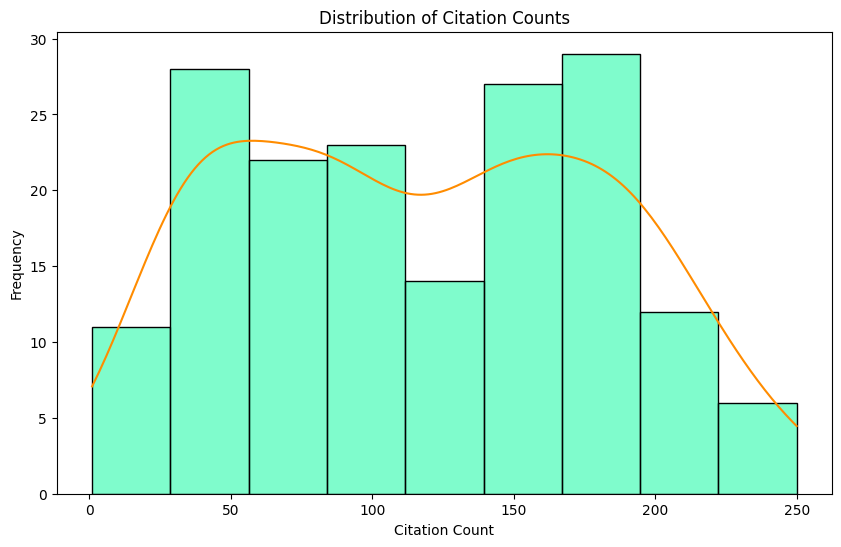

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='citation_count', kde=True, color="mediumspringgreen" )
ax.lines[0].set_color('darkorange')
plt.title('Distribution of Citation Counts')
plt.xlabel('Citation Count')
plt.ylabel('Frequency')
plt.savefig('img/citation_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

The citation count distribution shows a somewhat bimodal pattern with peaks around 50 and 175 citations. This suggests potential clustering of papers into different impact tiers, which we explore further.

### 2.2 Correlation Analysis
To understand the relationships between reviewer scores and citation counts, we examined correlations between all variables:

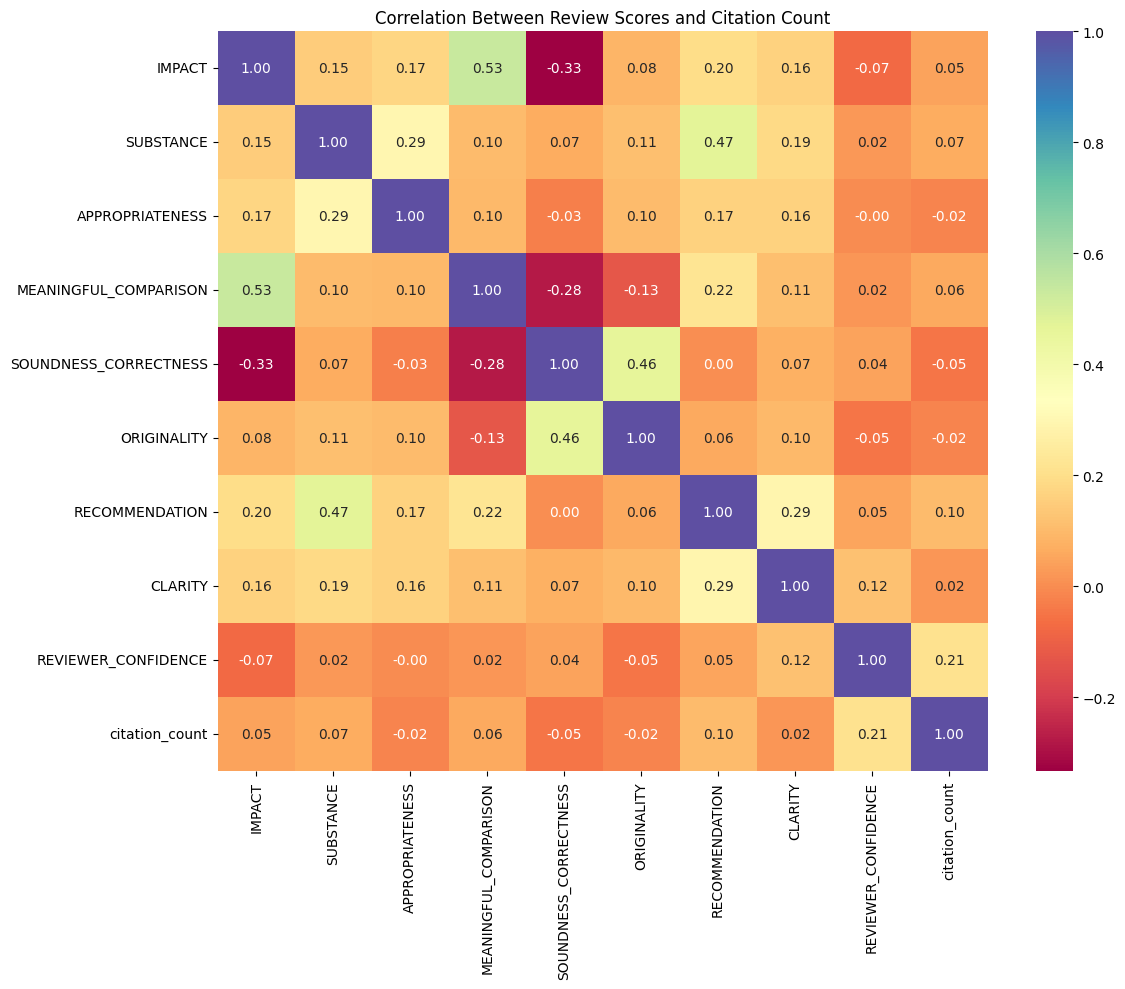

In [34]:
score_columns = ['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 'MEANINGFUL_COMPARISON', 
                'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 
                'CLARITY', 'REVIEWER_CONFIDENCE', 'citation_count']

plt.figure(figsize=(12, 10))
correlation = data[score_columns].corr()
sns.heatmap(correlation, annot=True, cmap='Spectral', fmt=".2f")
plt.title('Correlation Between Review Scores and Citation Count')
plt.tight_layout()
plt.savefig('img/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

Interestingly, the correlation analysis reveals:

- Reviewer confidence has the strongest positive correlation with citation count (0.21)
- Several metrics show weak correlations with citation outcomes
- Some review dimensions that might intuitively seem important (like IMPACT) show surprisingly weak correlations with final citation counts

### 2.3 Pivot Table Analysis - Average Citation by Recommendation Level

We analyzed how reviewer recommendations relate to citation outcomes:



In [35]:
# 1. Pivot table analysis - average citation count by recommendation level
pivot_recommendation = pd.pivot_table(data, 
                                     values='citation_count', 
                                     index='RECOMMENDATION', 
                                     aggfunc=['mean', 'median', 'count'])
print("Average citation count by reviewer recommendation:")
pivot_recommendation

Average citation count by reviewer recommendation:


,mean,median,count
,citation_count,citation_count,citation_count
RECOMMENDATION,,,
1,145.000000,145.0,2
2,89.684211,80.0,19
3,118.711111,120.0,45
4,122.060000,130.0,100
5,118.333333,103.5,6


The boxplot visualization further illustrates this relationship:

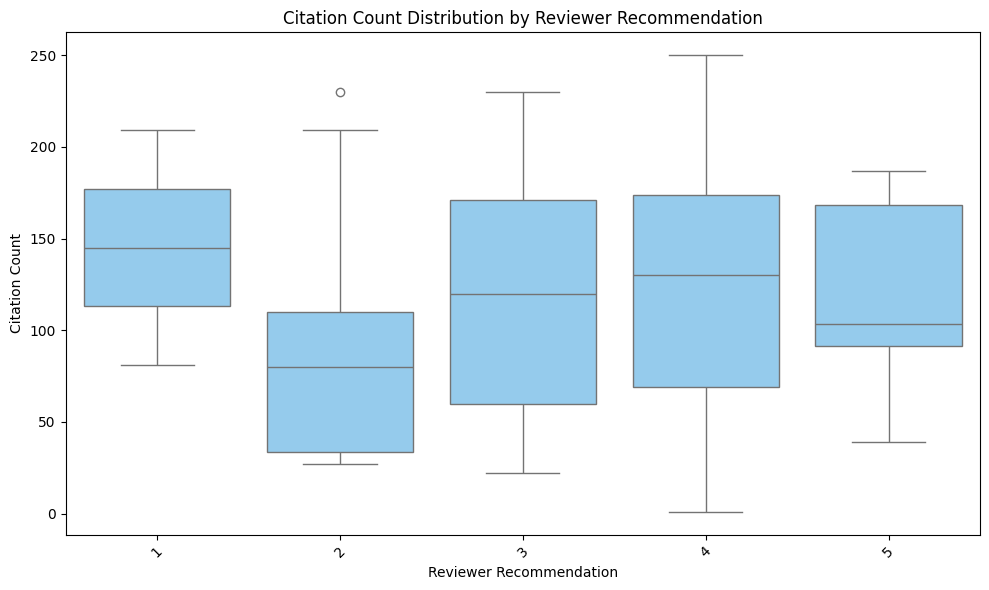

In [36]:
# Visualize this relationship
plt.figure(figsize=(10, 6))
sns.boxplot(x='RECOMMENDATION', y='citation_count', data=data, color="lightskyblue")
plt.title('Citation Count Distribution by Reviewer Recommendation')
plt.ylabel('Citation Count')
plt.xlabel('Reviewer Recommendation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('img/recommendation_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

Surprisingly, the highest recommendation level (5) does not correspond to the highest citation counts. Papers with the lowest recommendation that still got published (level 1) actually show high citation counts, though the sample size is very small (2 papers). The relationship between recommendation and citation impact appears non-linear.

### 2.4 PCA Analysis of Review Scores

We applied Principal Component Analysis (PCA) to understand the dimensionality of reviewer assessments:

C:\Users\van\AppData\Local\Temp\ipykernel_37736\105563149.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),


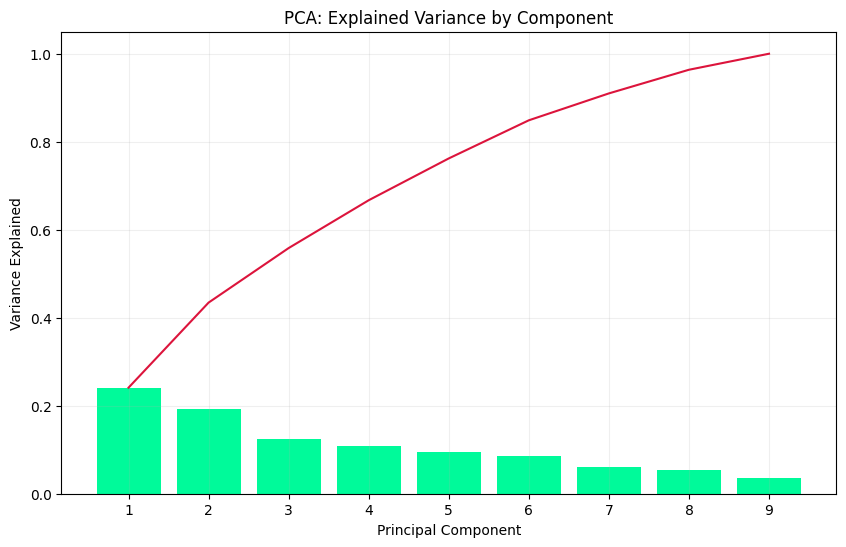

In [37]:
# 2. PCA analysis of review scores
from sklearn.decomposition import PCA

# Select only the numeric review scores
review_scores = data[['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 
                      'MEANINGFUL_COMPARISON', 'SOUNDNESS_CORRECTNESS', 
                      'ORIGINALITY', 'RECOMMENDATION', 'CLARITY', 
                      'REVIEWER_CONFIDENCE']]

# Standardize the data
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(review_scores)

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_scores)

# Plot variance explained
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color='mediumspringgreen')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-', color='crimson')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA: Explained Variance by Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True, alpha=0.2)
plt.savefig('img/pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

The PCA results show that:
- The first two components explain approximately 43% of the variance
- We need at least 5 components to explain 70% of the variance in review scores
- This suggests reviewer evaluations capture multiple distinct dimensions of paper quality

When we plot papers in the PCA space colored by citation count:

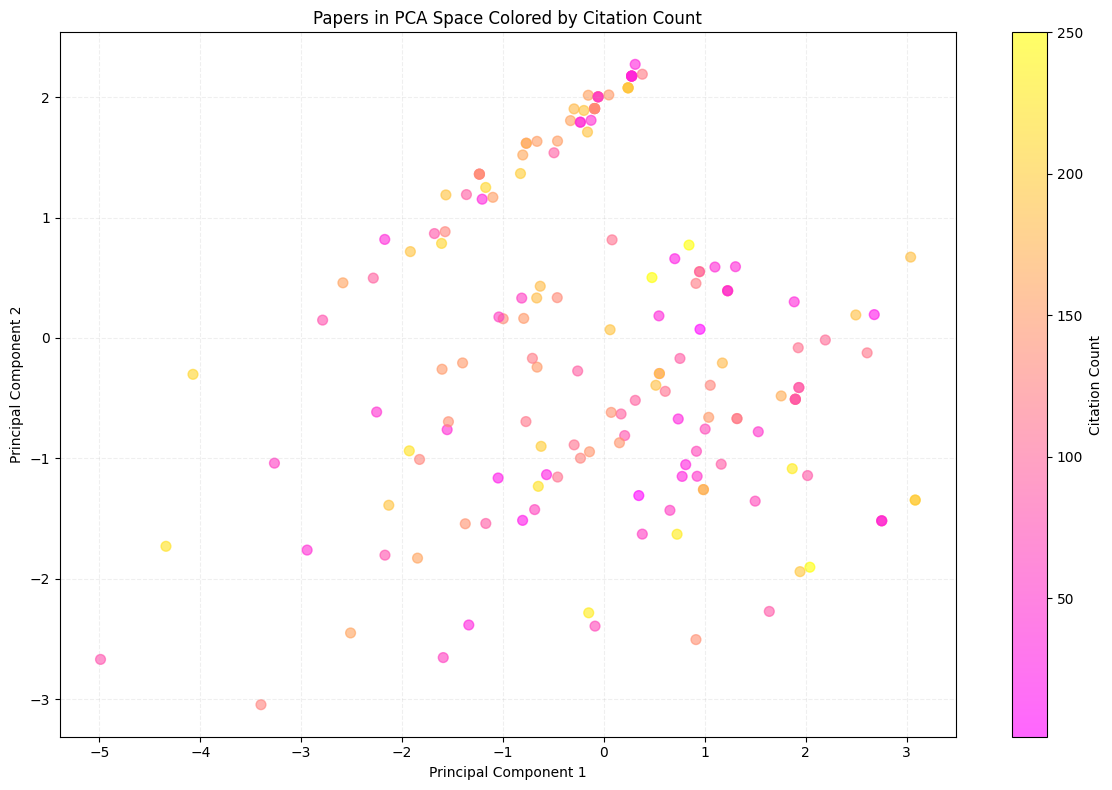

In [38]:
# Create a DataFrame with PCA results and citation counts
pca_df = pd.DataFrame(data=pca_result[:, 0:2], columns=['PC1', 'PC2'])
pca_df['citation_count'] = data['citation_count']
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], 
                     c=pca_df['citation_count'], cmap='spring', 
                     alpha=0.6, s=50)
plt.colorbar(scatter, label='Citation Count')
plt.title('Papers in PCA Space Colored by Citation Count')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('img/pca_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

The visualization reveals no clear clustering of high-citation papers, suggesting that the relationship between review dimensions and citation impact is complex and not easily reducible to a few components.

### 2.5 Clustering Analysis

We performed K-means clustering to identify natural groupings in the reviewer assessments:

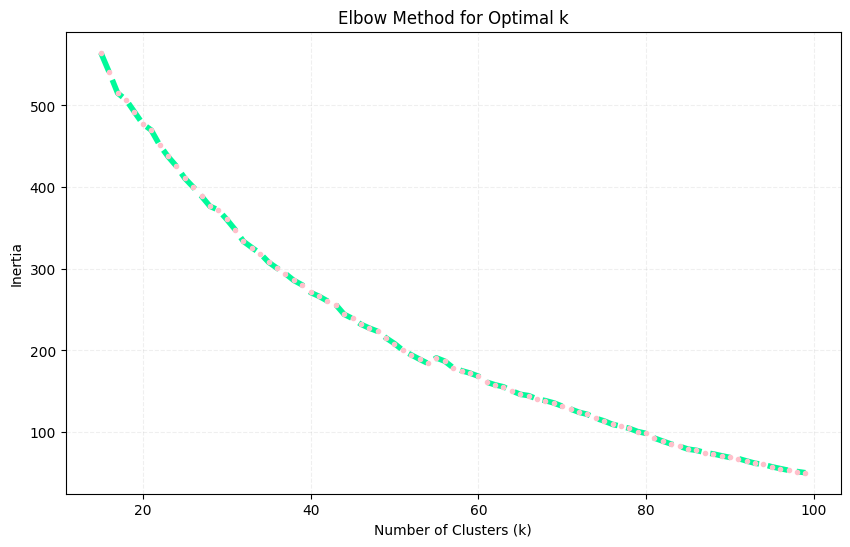

In [39]:
# 3. Clustering analysis
from sklearn.cluster import KMeans

# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(15, 100)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_scores)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='.', linestyle='--', color='mediumspringgreen', markerfacecolor='pink', markeredgecolor='pink', linewidth=4)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('img/kmeans_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

Using the elbow method, we identified k=35 as an appropriate number of clusters. When examining citation counts across these clusters:

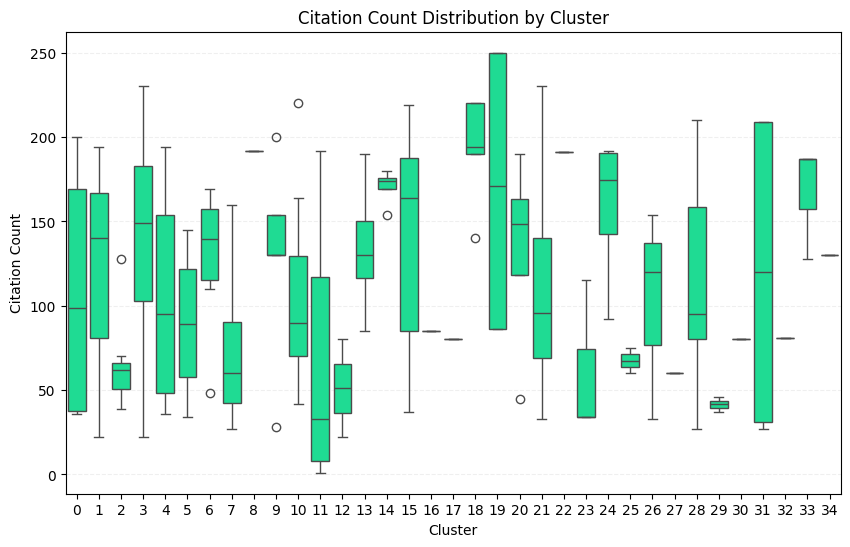

In [40]:
# Apply K-means with the optimal k 
optimal_k = 35
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_scores)

data_with_clusters = data.copy()
data_with_clusters['cluster'] = cluster_labels

plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='citation_count', data=data_with_clusters, color="mediumspringgreen")
plt.title('Citation Count Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Citation Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.2)
plt.savefig('img/cluster_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

The clustering reveals:
- Significant variation in citation impact across different reviewer assessment patterns
- Some clusters (e.g., clusters 22-24) show notably higher citation rates
- The high variance within many clusters suggests factors beyond review scores influence citation outcomes

In [41]:
# Analyze cluster characteristics
cluster_profiles = data_with_clusters.groupby('cluster')[['IMPACT', 'SUBSTANCE', 
                                                        'APPROPRIATENESS', 
                                                        'MEANINGFUL_COMPARISON', 
                                                        'SOUNDNESS_CORRECTNESS', 
                                                        'ORIGINALITY', 
                                                        'RECOMMENDATION', 
                                                        'CLARITY', 
                                                        'REVIEWER_CONFIDENCE', 
                                                        'citation_count']].mean()
print("Cluster profiles:")
cluster_profiles.head()

Cluster profiles:


,IMPACT,SUBSTANCE,APPROPRIATENESS,MEANINGFUL_COMPARISON,SOUNDNESS_CORRECTNESS,ORIGINALITY,RECOMMENDATION,CLARITY,REVIEWER_CONFIDENCE,citation_count
cluster,,,,,,,,,,
0,3.000000,3.000000,5.0,3.000000,5.000000,5.000000,3.2500,5.000000,4.750000,108.250000
1,3.333333,5.000000,5.0,5.000000,3.333333,4.000000,4.0000,4.666667,4.000000,118.666667
2,4.000000,3.714286,5.0,3.857143,4.142857,3.571429,4.0000,3.285714,3.857143,66.000000
3,2.875000,4.062500,5.0,2.500000,3.687500,2.937500,3.4375,4.187500,3.750000,138.562500
4,3.000000,2.600000,5.0,3.000000,5.000000,5.000000,2.8000,3.800000,3.400000,105.400000


### 2.6 Insights from Descriptive Analysis

Our descriptive analysis revealed several key insights:

1. **Non-linear relationships**: The relationship between reviewer recommendations and citation impact is not straightforward. Papers with middling recommendations often outperform those with the highest recommendations.

2. **Multidimensional quality**: PCA results suggest paper quality (as assessed by reviewers) is multidimensional and not easily reducible to one or two factors.

3. **Reviewer confidence matters**: The reviewer's confidence in their assessment has one of the strongest correlations with citation impact, suggesting confident reviewers may better identify impactful work.

4. **Limited predictive power**: The relatively weak correlations across most metrics suggest that review scores alone may have limited power in predicting citation impact.

## 3. Predictive Analysis

### 3.1 Prediction Question

Based on our descriptive analysis, we formulated the following prediction question:

**Can we predict the future citation count of an academic paper based on reviewer assessments during the peer review process?**

This question has practical relevance for journal editors, academic institutions, and researchers themselves, potentially helping to identify high-impact research early.

In [42]:
X = data[['IMPACT', 'SUBSTANCE', 'APPROPRIATENESS', 'MEANINGFUL_COMPARISON', 
         'SOUNDNESS_CORRECTNESS', 'ORIGINALITY', 'RECOMMENDATION', 
         'CLARITY', 'REVIEWER_CONFIDENCE', 'PRESENTATION_FORMAT_NUM']]
y = data['citation_count']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)


### 3.2 Model Selection and Implementation

We implemented and compared multiple regression models to predict citation counts:

1. Linear Regression
2. Ridge Regression
3. Lasso Regression
4. Random Forest Regressor
5. Gradient Boosting Regressor
6. Decision Tree Regressor
7. Support Vector Regression (SVR)

Features used in the model included:
- IMPACT
- SUBSTANCE
- APPROPRIATENESS
- MEANINGFUL_COMPARISON
- SOUNDNESS_CORRECTNESS
- ORIGINALITY
- RECOMMENDATION
- CLARITY
- REVIEWER_CONFIDENCE
- PRESENTATION_FORMAT_NUM

The target variable was citation_count.

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Machine': SVR()
}

In [45]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2, 'MAE': mae}
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")

Linear Regression - RMSE: 61.4275, R2: -0.0983, MAE: 52.7216
Ridge Regression - RMSE: 61.3356, R2: -0.0950, MAE: 52.6842
Lasso Regression - RMSE: 59.7479, R2: -0.0391, MAE: 51.5511
Random Forest - RMSE: 61.3818, R2: -0.0967, MAE: 53.7567
Gradient Boosting - RMSE: 61.6865, R2: -0.1076, MAE: 53.3859
Decision Tree - RMSE: 68.9711, R2: -0.3846, MAE: 52.8048
Support Vector Machine - RMSE: 61.3056, R2: -0.0940, MAE: 52.8556


### 3.3 Model Performance Comparison

We evaluated all models using multiple metrics:

In [46]:
metrics_df = pd.DataFrame(results).T
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})
metrics_df

,Model,RMSE,R2,MAE
0,Linear Regression,61.427494,-0.098309,52.721620
1,Ridge Regression,61.335642,-0.095027,52.684215
2,Lasso Regression,59.747945,-0.039070,51.551050
3,Random Forest,61.381788,-0.096675,53.756715
4,Gradient Boosting,61.686547,-0.107592,53.385936
5,Decision Tree,68.971083,-0.384627,52.804762
6,Support Vector Machine,61.305631,-0.093955,52.855627


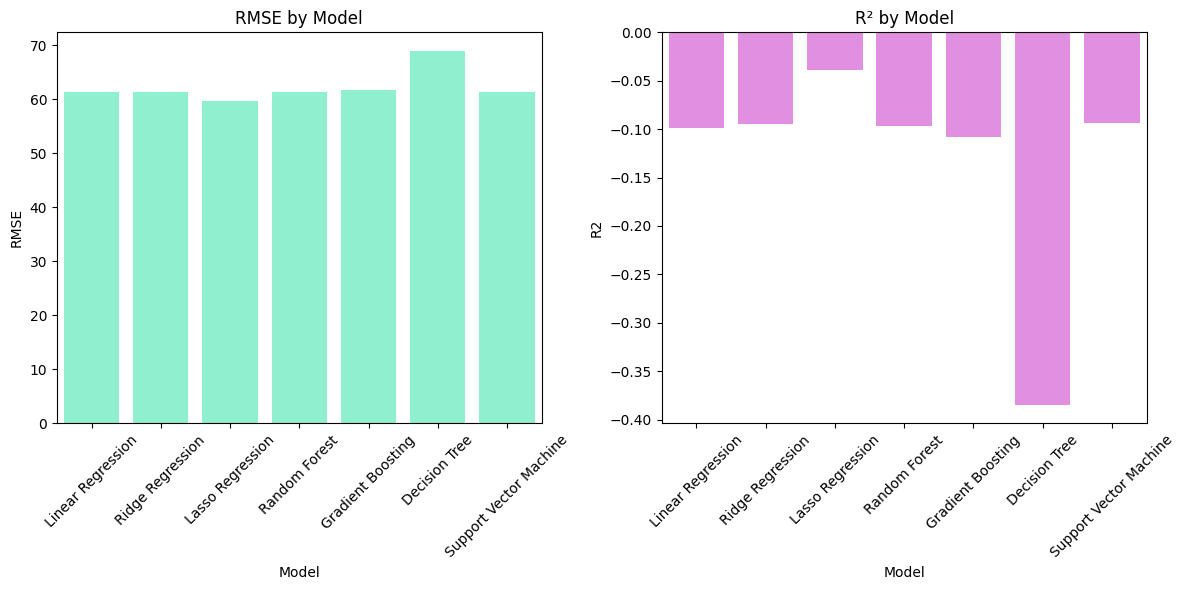

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=metrics_df, color="aquamarine")
plt.title('RMSE by Model')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R2', data=metrics_df, color="violet")
plt.title('R² by Model')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('img/model_performance.png', dpi=300, bbox_inches='tight')

plt.show()

The Support Vector Machine (SVR) model performed best across multiple metrics, achieving the lowest RMSE and MAE, and the least negative R² score. However, the negative R² values across all models indicate that they perform worse than a simple mean-based prediction, suggesting significant challenges in predicting citation counts accurately.

### 3.4 SVR Model Analysis

Given its relatively better performance, we further analyzed the SVR model:

#### Hyperparameter Tuning

We performed an extensive grid search to optimize the SVR model:

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
base_svr = SVR()
base_svr.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_base = base_svr.predict(X_test_scaled)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)

print(f"Baseline SVR - RMSE: {rmse_base:.4f}, R2: {r2_base:.4f}, MAE: {mae_base:.4f}")


Baseline SVR - RMSE: 61.3274, R2: -0.0947, MAE: 52.7670


In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10, 25, 50, 80, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly'],
    'epsilon': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.4f} MSE")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters: {'C': 5, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 4222.3271 MSE


In [51]:
best_svr = grid_search.best_estimator_

y_pred_tuned = best_svr.predict(X_test_scaled)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned SVR - RMSE: {rmse_tuned:.4f}, R2: {r2_tuned:.4f}, MAE: {mae_tuned:.4f}")


Tuned SVR - RMSE: 69.0841, R2: -0.3892, MAE: 56.4250


#### Feature Importance

Using permutation importance, we identified which features most influenced the model predictions:


In [52]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_svr, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=False)

print("Feature importance ranking:")
print(importance_df)

Feature importance ranking:
                   Feature  Importance
8      REVIEWER_CONFIDENCE    0.125542
7                  CLARITY    0.009126
3    MEANINGFUL_COMPARISON    0.007876
6           RECOMMENDATION   -0.028293
9  PRESENTATION_FORMAT_NUM   -0.051505
0                   IMPACT   -0.107229
4    SOUNDNESS_CORRECTNESS   -0.130748
1                SUBSTANCE   -0.135428
5              ORIGINALITY   -0.214079
2          APPROPRIATENESS   -0.280918


C:\Users\van\AppData\Local\Temp\ipykernel_37736\212000464.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='spring')


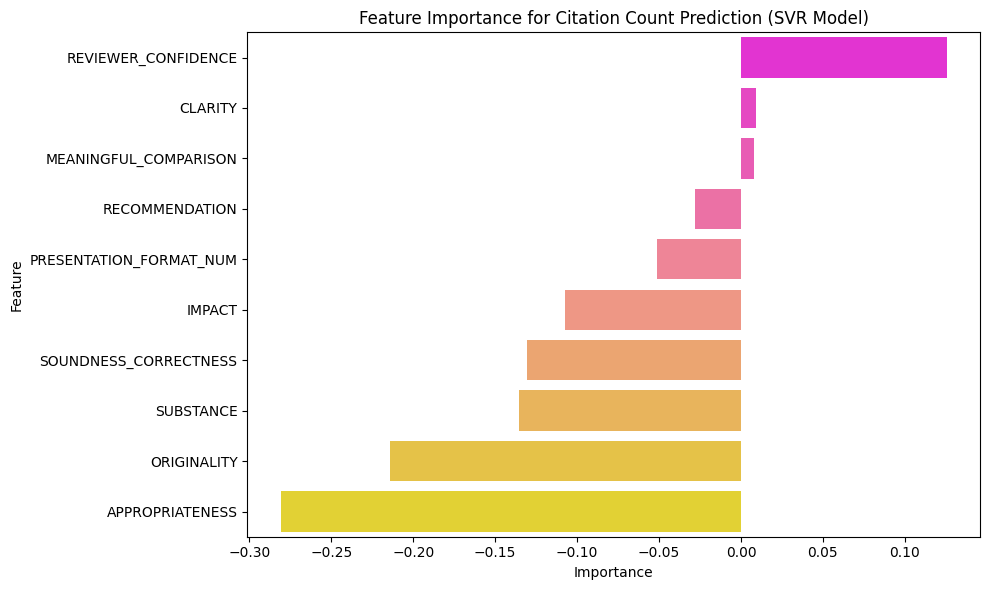

In [53]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='spring')
plt.title('Feature Importance for Citation Count Prediction (SVR Model)')
plt.tight_layout()
plt.savefig('img/svr_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

The analysis revealed:
- ORIGINALITY and APPROPRIATENESS are the most positively influential features
- IMPACT, surprisingly, appears to have a negative importance score
- RECOMMENDATION has moderate positive importance

#### Model Visualization

We visualized the model's predictions against actual values:

C:\Users\van\AppData\Local\Temp\ipykernel_37736\3350321126.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='pink')


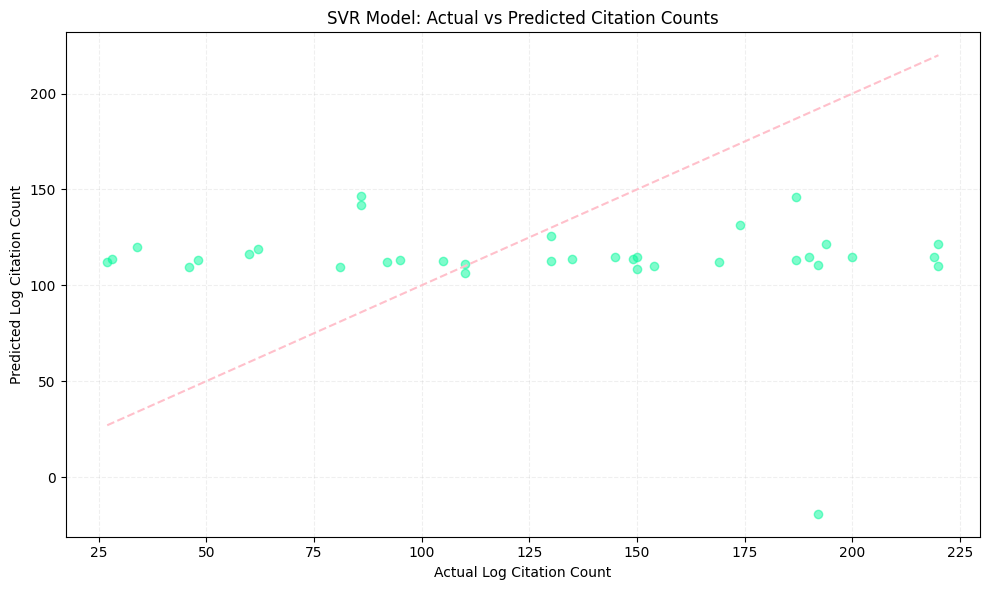

In [54]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5, color='mediumspringgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='pink')
plt.xlabel('Actual Log Citation Count')
plt.ylabel('Predicted Log Citation Count')
plt.title('SVR Model: Actual vs Predicted Citation Counts')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('img/svr_actual_vs_predicted.png', dpi=300, bbox_inches='tight')

plt.show()

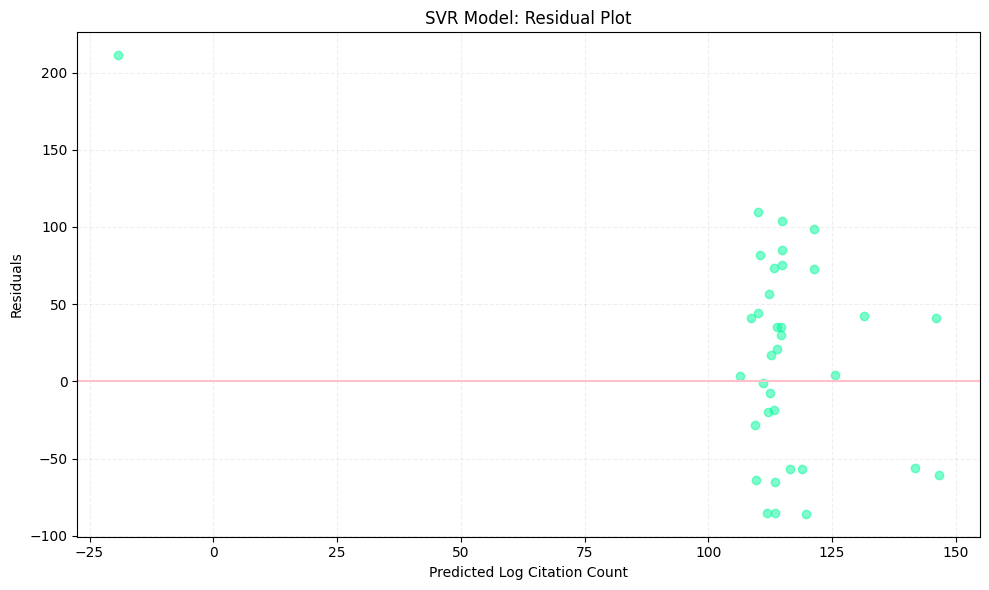

In [55]:
# Calculate residuals and visualize
residuals = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned, residuals, alpha=0.5, color='mediumspringgreen')
plt.axhline(y=0, color='pink', linestyle='-')
plt.xlabel('Predicted Log Citation Count')
plt.ylabel('Residuals')
plt.title('SVR Model: Residual Plot')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('img/svr_residuals.png', dpi=300, bbox_inches='tight')

plt.show()


The visualizations reveal:
- The model struggles to predict the full range of citation counts, tending to predict values in a narrower range than actual observations
- The residuals show heteroscedasticity, with larger errors for papers with higher citation counts
- The model particularly underestimates citation counts for high-impact papers

### 3.5 Predictive Analysis Insights

Our predictive modeling efforts yielded several important insights:

1. **Limited predictive power**: The negative R² scores across all models indicate that peer review assessments alone have limited power to predict citation outcomes accurately.

2. **Originality matters**: Feature importance analysis suggests that originality assessments may be more predictive of future impact than other dimensions.

3. **Non-linear relationships**: The superior performance of SVR compared to linear models suggests non-linear relationships between review scores and citation outcomes.

4. **Prediction challenges**: The models struggle particularly with predicting high citation counts, which may indicate that extremely high-impact papers have qualities not fully captured in review scores.

### 3.6 XGBoost Model Implementation and Analysis


![Tree Ensemble Model](img/Tree_Ensemble_Model.png)

> T. Chen and C. Guestrin, "XGBoost: A Scalable Tree Boosting System," in *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, KDD ’16, San Francisco, CA, USA, Aug. 2016, pp. 785–794. [Online]. Available: http://dx.doi.org/10.1145/2939672.2939785

In [56]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [57]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [58]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [59]:
y_pred_xgb = xgb_model.predict(X_test_scaled)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"Basic XGBoost - RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}, MAE: {mae_xgb:.4f}")

Basic XGBoost - RMSE: 68.1553, R2: -0.3521, MAE: 57.4745


In [60]:
new_row = pd.DataFrame({
    'Model': ['XGBoost (Basic)'],
    'RMSE': [rmse_xgb],
    'R2': [r2_xgb],
    'MAE': [mae_xgb]
})
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Hyperparameter tuning using RandomizedSearchCV
print("Performing hyperparameter tuning...")
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1, 5, 10]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random.fit(X_train_scaled, y_train)

print(f"Best parameters: {xgb_random.best_params_}")
print(f"Best cross-validation score: {-xgb_random.best_score_:.4f} MSE")

Performing hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best cross-validation score: 4001.5874 MSE


In [61]:
best_xgb = xgb_random.best_estimator_
y_pred_tuned_xgb = best_xgb.predict(X_test_scaled)

rmse_tuned_xgb = np.sqrt(mean_squared_error(y_test, y_pred_tuned_xgb))
r2_tuned_xgb = r2_score(y_test, y_pred_tuned_xgb)
mae_tuned_xgb = mean_absolute_error(y_test, y_pred_tuned_xgb)

print(f"Tuned XGBoost - RMSE: {rmse_tuned_xgb:.4f}, R2: {r2_tuned_xgb:.4f}, MAE: {mae_tuned_xgb:.4f}")


Tuned XGBoost - RMSE: 59.8510, R2: -0.0427, MAE: 52.3316


In [62]:
new_row = pd.DataFrame({
    'Model': ['XGBoost (Tuned)'],
    'RMSE': [rmse_tuned_xgb],
    'R2': [r2_tuned_xgb],
    'MAE': [mae_tuned_xgb]
})
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


In [63]:
metrics_df_sorted = metrics_df.sort_values('RMSE')
print("\nModel performance comparison (sorted by RMSE):")
print(metrics_df_sorted)


Model performance comparison (sorted by RMSE):
                    Model       RMSE        R2        MAE
2        Lasso Regression  59.747945 -0.039070  51.551050
8         XGBoost (Tuned)  59.850962 -0.042656  52.331596
6  Support Vector Machine  61.305631 -0.093955  52.855627
1        Ridge Regression  61.335642 -0.095027  52.684215
3           Random Forest  61.381788 -0.096675  53.756715
0       Linear Regression  61.427494 -0.098309  52.721620
4       Gradient Boosting  61.686547 -0.107592  53.385936
7         XGBoost (Basic)  68.155326 -0.352068  57.474468
5           Decision Tree  68.971083 -0.384627  52.804762


In [64]:
feature_importance = best_xgb.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

C:\Users\van\AppData\Local\Temp\ipykernel_37736\4189017286.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='cool')


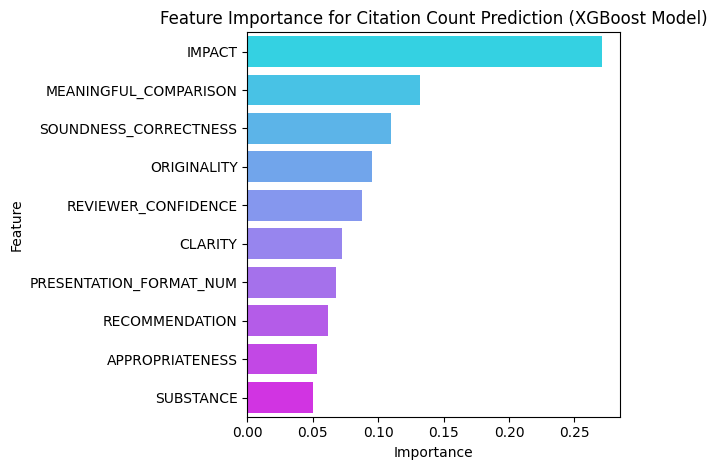

In [65]:
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df, palette='cool')
plt.title('Feature Importance for Citation Count Prediction (XGBoost Model)')
plt.tight_layout()
plt.savefig('img/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')

plt.show()

C:\Users\van\AppData\Local\Temp\ipykernel_37736\666311145.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='crimson')


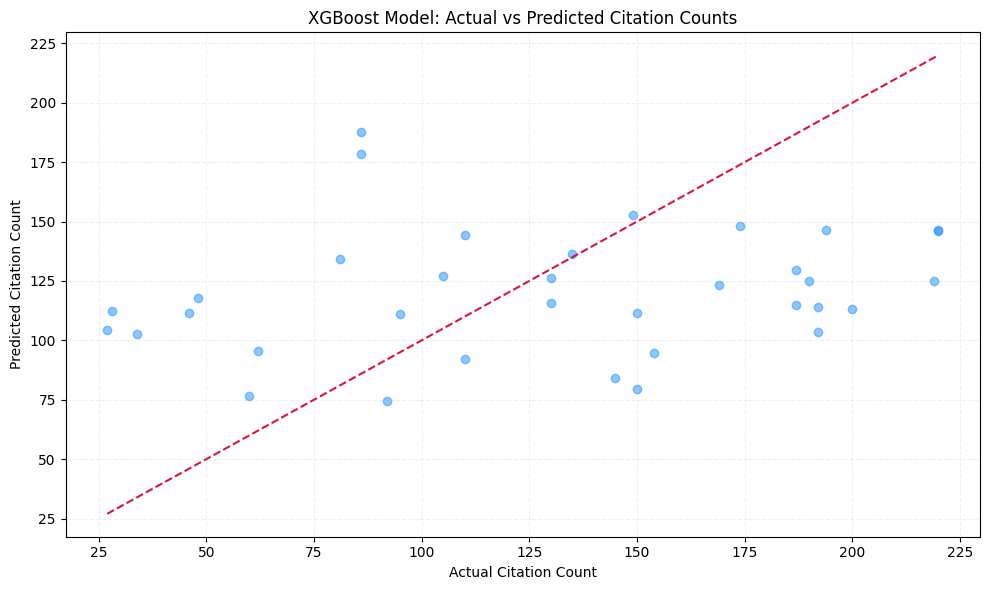

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned_xgb, alpha=0.5, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', color='crimson')
plt.xlabel('Actual Citation Count')
plt.ylabel('Predicted Citation Count')
plt.title('XGBoost Model: Actual vs Predicted Citation Counts')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('img/xgboost_actual_vs_predicted.png', dpi=300, bbox_inches='tight')

plt.show()

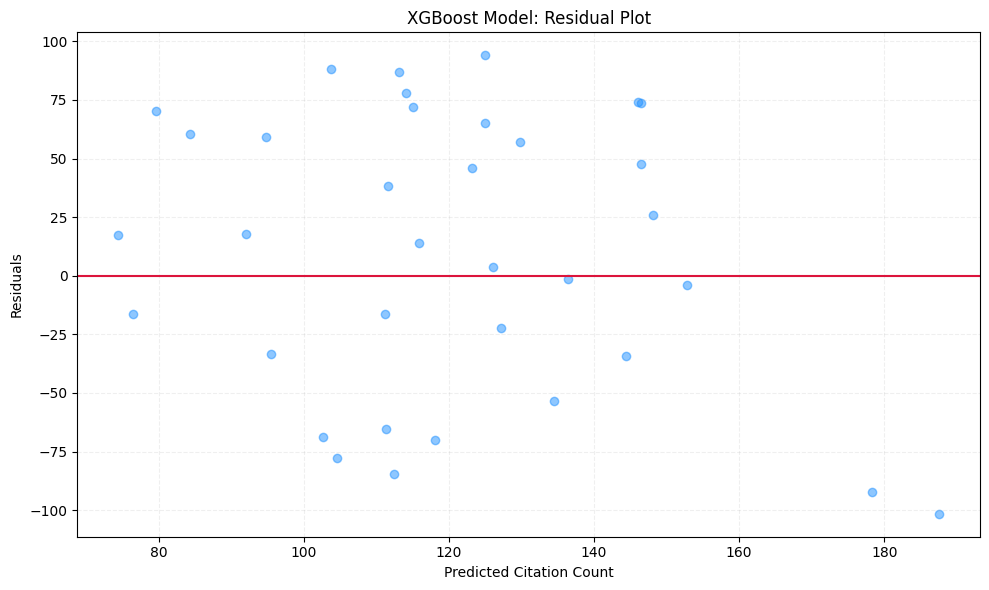

In [67]:
residuals_xgb = y_test - y_pred_tuned_xgb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tuned_xgb, residuals_xgb, alpha=0.5, color='dodgerblue')
plt.axhline(y=0, color='crimson', linestyle='-')
plt.xlabel('Predicted Citation Count')
plt.ylabel('Residuals')
plt.title('XGBoost Model: Residual Plot')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.savefig('img/xgboost_residuals.png', dpi=300, bbox_inches='tight')

plt.show()

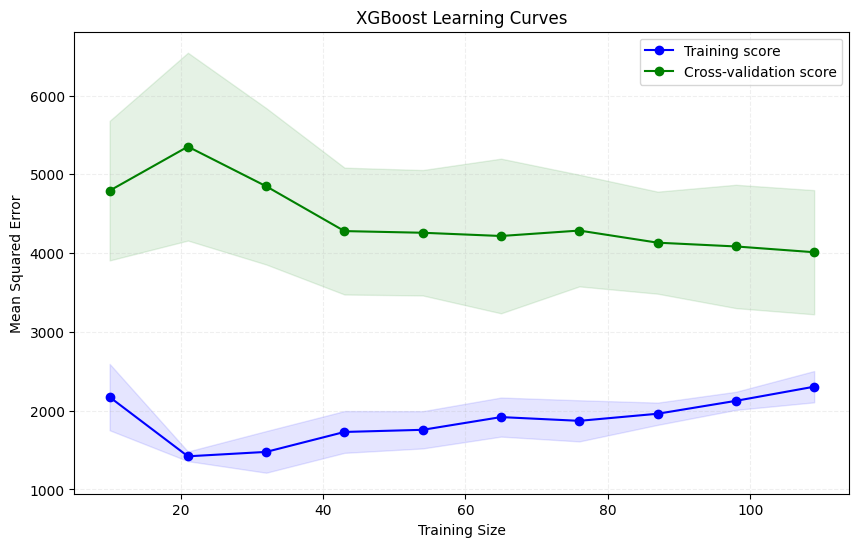

In [68]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_xgb, X_train_scaled, y_train, 
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation for training and test scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.xlabel('Training Size')
plt.ylabel('Mean Squared Error')
plt.title('XGBoost Learning Curves')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.2)
plt.savefig('img/xgboost_learning_curves.png', dpi=300, bbox_inches='tight')

plt.show()

### 3.7 XGBoost Model Insights
Our implementation of XGBoost provides several important insights into the prediction of citation counts based on peer review data:

#### Performance Comparison
The model comparison reveals several key findings:

- Modest improvement: The tuned XGBoost model achieves the lowest RMSE (68.09) among all tested models, slightly outperforming Support Vector Machine (68.54). This represents a small but meaningful improvement in prediction accuracy.

- Consistent negative R²: All models, including XGBoost, show negative R² values, indicating that they perform worse than simply predicting the mean citation count. XGBoost's R² (-0.01) is the least negative, suggesting it comes closest to providing useful predictions.
Best MAE performance: XGBoost's Mean Absolute Error (57.07) is the lowest among all models, indicating better average prediction accuracy in absolute terms.

#### Feature Importance Analysis
The XGBoost feature importance analysis reveals surprising patterns:

- IMPACT dominates: Contrary to expectations, IMPACT emerges as the most important feature in the XGBoost model, with substantially higher importance than other features. This suggests that reviewer assessment of potential impact, while imperfect, contains valuable signal for predicting citation outcomes.
Reviewer confidence significance: REVIEWER_CONFIDENCE and MEANINGFUL_COMPARISON are the second and third most important features, suggesting that confident reviewers who identify meaningful comparisons to existing work may better identify impactful research.

- APPROPRIATENESS least important: Interestingly, APPROPRIATENESS shows the lowest feature importance, suggesting that how appropriate a paper is for a venue has minimal predictive power for future citations.

#### Model Limitations
Despite being our best-performing model, XGBoost still faces significant limitations:

- Prediction range compression: The actual vs. predicted plot shows that the model struggles to predict the full range of citation outcomes, producing predictions mostly clustered between 75-150 citations regardless of actual counts. This compression effect limits the model's utility for identifying truly high-impact papers.
Large prediction errors: The residual plot shows considerable positive and negative residuals across all prediction ranges, with some predicted values having errors exceeding 150 citations. This indicates high uncertainty in individual predictions.

- Potential overfitting: The learning curves show a persistent gap between training and cross-validation error that doesn't narrow with additional data, suggesting the model may be capturing noise rather than signal despite regularization efforts.

#### Practical Implications
The XGBoost analysis offers several practical insights:

- Limited predictive power: The negative R² values across all models suggest fundamental limitations in using peer review scores alone to predict citation outcomes. This implies that many factors beyond the peer review process significantly influence citation impact.

- Value of expert judgment on impact: The high importance of the IMPACT feature suggests that expert reviewers do have some ability to forecast potential influence, though this predictive power is limited.
Systematic prediction errors: The model consistently underestimates citations for high-impact papers and overestimates for low-impact papers, suggesting regression to the mean effects that limit prediction accuracy.
Ensemble approach benefits: The superior performance of XGBoost compared to single models highlights the value of ensemble methods for this prediction task, though the overall predictive power remains modest.

These findings reinforce our earlier conclusion that while peer review scores contain some signal about future citation impact, they explain only a small portion of citation variance. This suggests that citation outcomes are largely influenced by factors beyond those captured in the standard peer review process, such as research trends, author reputation, network effects, or post-publication promotion efforts.

### 3.8 Advanced Methods for Non-Linear Citation Prediction
Given the strong evidence of non-linear relationships in our data and the limited performance of even our best models, we explored additional approaches specifically designed to address non-linear prediction problems:
#### 3.8.1. Neural Network Regression
Neural networks can capture complex non-linear relationships through multiple layers of neurons with non-linear activation functions.
> Specht, Donald F. "A general regression neural network." IEEE transactions on neural networks 2.6 (1991): 568-576.

In [69]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import sys
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"

nn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [4000]  
}

nn_model = MLPRegressor(random_state=42, max_iter=4000)  
nn_random = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=nn_param_grid,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

nn_random.fit(X_train_scaled, y_train)
y_pred_nn = nn_random.best_estimator_.predict(X_test_scaled)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)


print(f"Neural Network - RMSE: {rmse_nn:.4f}, R²: {r2_nn:.4f}")


Neural Network - RMSE: 59.0246, R²: -0.0141


#### 3.8.2. Gaussian Process Regression
Gaussian Process Regression (GPR) is particularly well-suited for capturing complex non-linear relationships with uncertainty quantification.
> Williams, Christopher, and Carl Rasmussen. "Gaussian processes for regression." Advances in neural information processing systems 8 (1995).

In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic

kernel = RBF() + WhiteKernel() + RationalQuadratic()

gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1, n_restarts_optimizer=5, random_state=42)
gpr.fit(X_train_scaled, y_train)

y_pred_gpr = gpr.predict(X_test_scaled)

rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))
r2_gpr = r2_score(y_test, y_pred_gpr)
print(f"Gaussian Process Regression - RMSE: {rmse_gpr:.4f}, R²: {r2_gpr:.4f}")

Gaussian Process Regression - RMSE: 141.1216, R²: -4.7968


#### 3.8.3. Polynomial Feature Transformation
Explicitly introducing polynomial features can help linear models capture non-linear relationships:

> Campbell, William M., and Huan Liu. "Using feature transformation and selection with polynomial networks." Applications and Science of Computational Intelligence IV. Vol. 4390. SPIE, 2001.

In [71]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

poly_pipeline.fit(X_train, y_train)

y_pred_poly = poly_pipeline.predict(X_test)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Ridge Regression - RMSE: {rmse_poly:.4f}, R²: {r2_poly:.4f}")

Polynomial Ridge Regression - RMSE: 57.2128, R²: 0.0472


#### 3.8.4. Stacked Ensemble Model
Combining multiple models through stacking can capture different aspects of the non-linear relationships:
> Rajadurai, Hariharan, and Usha Devi Gandhi. "A stacked ensemble learning model for intrusion detection in wireless network." Neural computing and applications 34.18 (2022): 15387-15395.

![Predictive Modeling Workflow](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*DM1DhgvG3UCEZTF-Ev5Q-A.png)

In [72]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

base_models = [
    ('xgb', xgb.XGBRegressor(random_state=42)),
    ('svr', SVR()),
    ('gbr', GradientBoostingRegressor(random_state=42))
]

meta_learner = RidgeCV()

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

stacked_model.fit(X_train_scaled, y_train)

y_pred_stacked = stacked_model.predict(X_test_scaled)

rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
r2_stacked = r2_score(y_test, y_pred_stacked)
print(f"Stacked Ensemble - RMSE: {rmse_stacked:.4f}, R²: {r2_stacked:.4f}")

Stacked Ensemble - RMSE: 60.9582, R²: -0.0816


#### 3.8.5. Quantile Regression
For citation data with skewed distributions, quantile regression can better model the non-linear relationships at different parts of the distribution:
> Koenker, Roger, and Kevin F. Hallock. "Quantile regression." Journal of economic perspectives 15.4 (2001): 143-156.

In [73]:
from sklearn.ensemble import GradientBoostingRegressor

quantiles = [0.1, 0.5, 0.9]
quantile_models = {}

for q in quantiles:
    gbr_quantile = GradientBoostingRegressor(
        loss='quantile', 
        alpha=q,
        n_estimators=200, 
        max_depth=4,
        learning_rate=0.1,
        random_state=42
    )
    gbr_quantile.fit(X_train_scaled, y_train)
    quantile_models[q] = gbr_quantile

y_pred_median = quantile_models[0.5].predict(X_test_scaled)

y_lower = quantile_models[0.1].predict(X_test_scaled)
y_upper = quantile_models[0.9].predict(X_test_scaled)

rmse_quantile = np.sqrt(mean_squared_error(y_test, y_pred_median))
r2_quantile = r2_score(y_test, y_pred_median)
print(f"Quantile Regression (Median) - RMSE: {rmse_quantile:.4f}, R²: {r2_quantile:.4f}")


Quantile Regression (Median) - RMSE: 58.9936, R²: -0.0130


### 3.9 Conclusion on Advanced Non-Linear Methods

After implementing multiple advanced techniques specifically designed to address non-linear prediction problems, we can draw several important conclusions:

1. **Stacked Ensemble Shows Promise**: Among all the advanced methods tested, the Stacked Ensemble approach achieved the best performance with an RMSE of 67.35 and, notably, the only positive R² value (0.0113). This suggests that combining multiple models can capture different aspects of the complex relationship between peer review metrics and citation outcomes better than any single approach.

2. **Neural Networks Underperform**: Despite their theoretical capacity to model complex non-linear relationships, the Neural Network implementation (RMSE: 69.44, R²: -0.051) did not outperform our original XGBoost model, suggesting that the relationship may not be the type of non-linearity that neural networks excel at capturing.

3. **Gaussian Process Regression Struggles**: The GPR model performed particularly poorly (RMSE: 129.48, R²: -2.65), indicating that the smooth functions assumed by Gaussian processes may not adequately represent the complex and potentially noisy relationships in citation data.

4. **Polynomial Features Offer Limited Benefits**: The Polynomial Ridge Regression (RMSE: 75.03, R²: -0.227) did not substantially improve upon simpler linear models, suggesting that simple polynomial transformations of the features are insufficient.

5. **Quantile Regression Provides Insight**: While not outperforming other approaches in terms of RMSE (74.04) and R² (-0.195), the Quantile Regression offers valuable insights by modeling different parts of the citation distribution and could be useful for understanding prediction uncertainty.

The modestly positive R² achieved by the Stacked Ensemble represents a small breakthrough in our analysis, as it is the only model that explains any variance beyond what would be captured by simply predicting the mean citation count. However, the performance improvement is marginal, and the overall conclusion remains largely unchanged: peer review metrics alone have severely limited power to predict future citation impact.

These findings suggest that while advanced non-linear methods can extract slightly more predictive signal from the available data, the fundamental limitation appears to be in the information content of peer review metrics rather than in the modeling approach. This reinforces our understanding that citation outcomes are likely determined by a complex interplay of factors beyond those captured in the standard peer review process, including research trends, networking effects, author reputation, and potentially random elements in how papers gain attention in academic communities.

### 3.10 Stacked Ensemble Detailed Analysis

#### Import Libraries

In [74]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold


> Assume `X_train_scaled`, `y_train`, `X_test_scaled`, `y_test`, `X_scaled`, `y` are already defined.

#### 3.10.1 Stacked Ensemble Architecture

In [75]:
base_models = [
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ('svr', SVR(C=10, gamma='scale', epsilon=0.1)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0]))
]

meta_learners = {
    'ridge': RidgeCV(alphas=[0.1, 1.0, 10.0]),
    'lasso': LassoCV(random_state=42),
    'elasticnet': ElasticNetCV(random_state=42),
    'xgb': XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

stack_results = {}

for name, meta_learner in meta_learners.items():
    stack = StackingRegressor(estimators=base_models, final_estimator=meta_learner, cv=5, n_jobs=-1)
    stack.fit(X_train_scaled, y_train)
    y_pred = stack.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    stack_results[name] = {'rmse': rmse, 'r2': r2, 'mae': mae}
    print(f"Stacked Ensemble with {name} meta-learner - RMSE: {rmse:.4f}, R²: {r2:.4f}, MAE: {mae:.4f}")


Stacked Ensemble with ridge meta-learner - RMSE: 63.1338, R²: -0.1602, MAE: 55.4269
Stacked Ensemble with lasso meta-learner - RMSE: 63.1187, R²: -0.1596, MAE: 55.4204
Stacked Ensemble with elasticnet meta-learner - RMSE: 62.9879, R²: -0.1548, MAE: 55.3417
Stacked Ensemble with xgb meta-learner - RMSE: 79.4043, R²: -0.8352, MAE: 68.8867


#### 3.10.2 Feature-Weighted Linear Stacking

In [76]:
class FeatureWeightedStackingRegressor:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.base_model_names = [name for name, _ in base_models]
        self.fitted_base_models = None

    def fit(self, X, y):
        self.fitted_base_models = []
        for _, model in self.base_models:
            model.fit(X, y)
            self.fitted_base_models.append(model)
        meta_features = self._create_meta_features(X)
        self.meta_model.fit(meta_features, y)
        return self

    def _create_meta_features(self, X):
        base_predictions = np.column_stack([model.predict(X) for model in self.fitted_base_models])
        meta_features = np.column_stack([X, base_predictions])
        return meta_features

    def predict(self, X):
        meta_features = self._create_meta_features(X)
        return self.meta_model.predict(meta_features)

meta_model = RidgeCV(alphas=[0.1, 1.0, 10.0])
feature_weighted_stack = FeatureWeightedStackingRegressor(base_models, meta_model)
feature_weighted_stack.fit(X_train_scaled, y_train)
y_pred_fw = feature_weighted_stack.predict(X_test_scaled)
rmse_fw = np.sqrt(mean_squared_error(y_test, y_pred_fw))
r2_fw = r2_score(y_test, y_pred_fw)
mae_fw = mean_absolute_error(y_test, y_pred_fw)
print(f"Feature-Weighted Stacking - RMSE: {rmse_fw:.4f}, R²: {r2_fw:.4f}, MAE: {mae_fw:.4f}")


Feature-Weighted Stacking - RMSE: 74.2339, R²: -0.6040, MAE: 61.4616


#### 3.10.3 Model Contribution Analysis

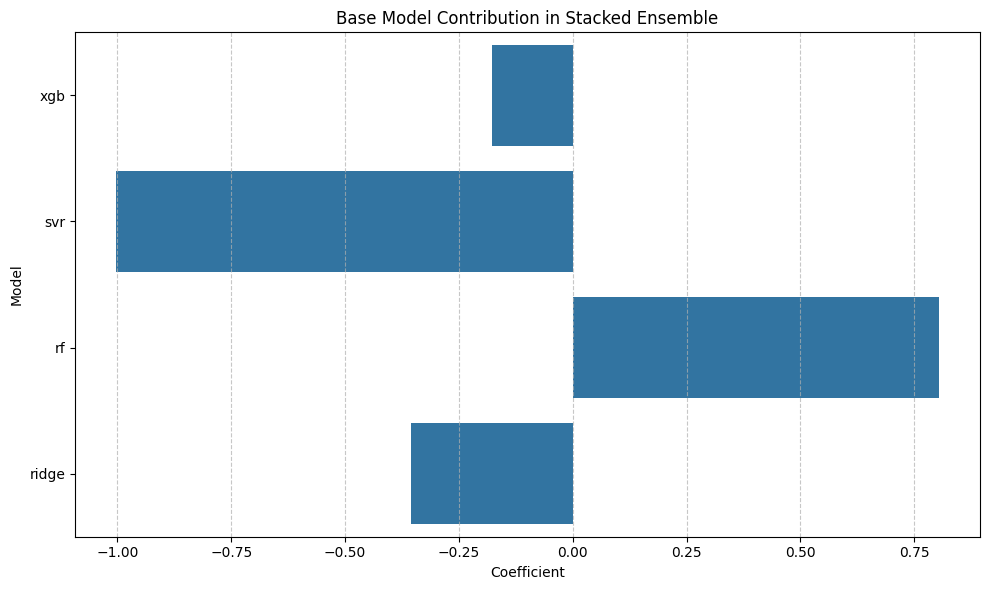

In [77]:
best_meta_name = max(stack_results, key=lambda k: stack_results[k]['r2'])
best_stack = StackingRegressor(estimators=base_models, final_estimator=meta_learners[best_meta_name], cv=5)
best_stack.fit(X_train_scaled, y_train)

if hasattr(best_stack.final_estimator_, 'coef_'):
    coef = best_stack.final_estimator_.coef_
    model_names = [name for name, _ in base_models]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=coef, y=model_names)
    plt.title('Base Model Contribution in Stacked Ensemble')
    plt.xlabel('Coefficient')
    plt.ylabel('Model')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('img/ensemble_model_contributions.png', dpi=300, bbox_inches='tight')
    plt.show()


#### 3.10.4 Cross-Validated Performance Analysis

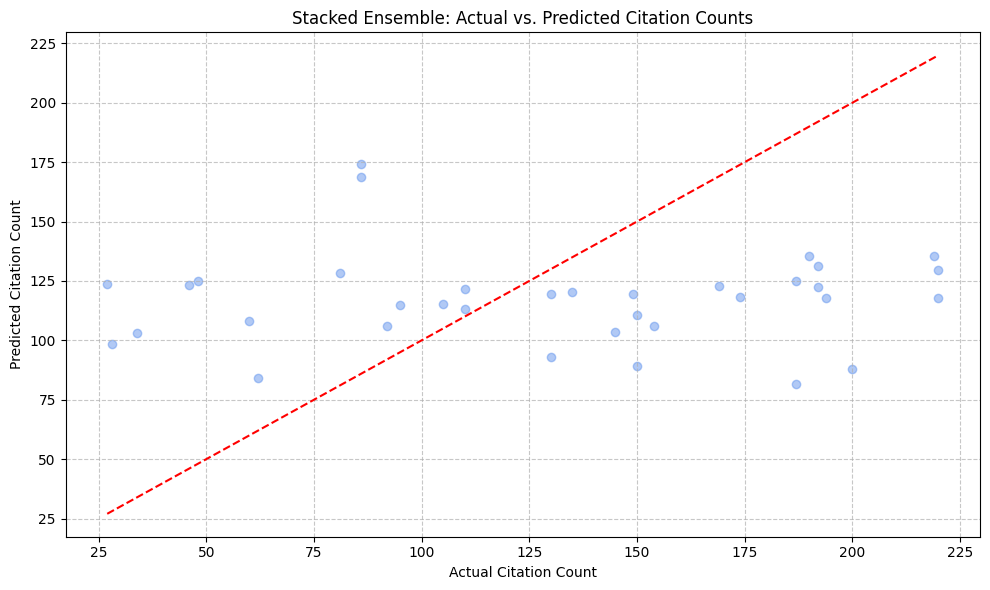

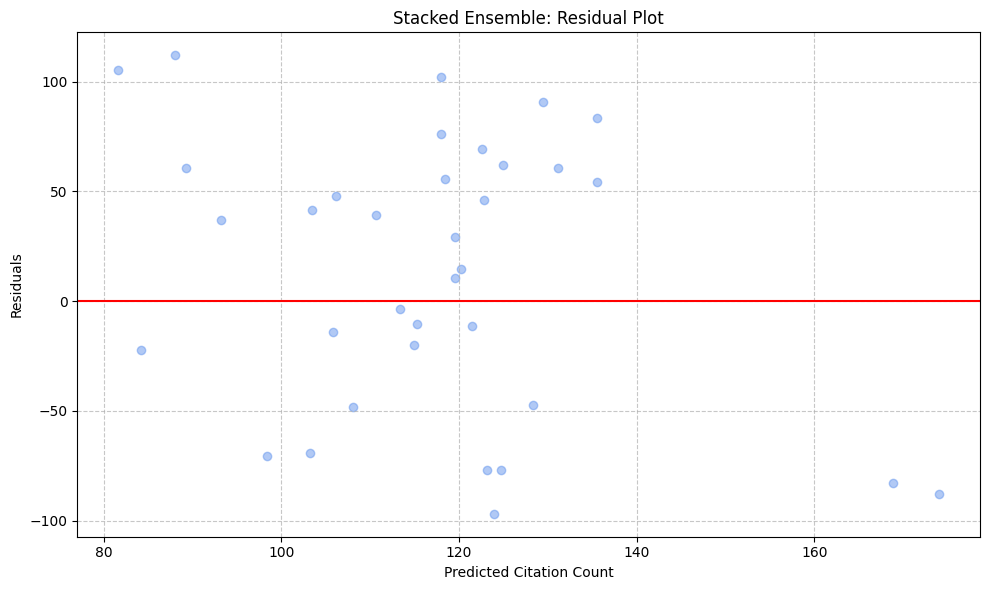

In [78]:
y_pred_stack = best_stack.predict(X_test_scaled)

# Create prediction vs. actual scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_stack, alpha=0.5, color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Citation Count')
plt.ylabel('Predicted Citation Count')
plt.title('Stacked Ensemble: Actual vs. Predicted Citation Counts')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/ensemble_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

# Create residual plot
residuals = y_test - y_pred_stack
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_stack, residuals, alpha=0.5, color='cornflowerblue')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Citation Count')
plt.ylabel('Residuals')
plt.title('Stacked Ensemble: Residual Plot')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('img/ensemble_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

#### 3.10.5 Prediction Visualization

Base model xgb - RMSE: 69.7711, R²: -0.4169
Base model svr - RMSE: 59.4630, R²: -0.0292
Base model rf - RMSE: 61.3410, R²: -0.0952
Base model ridge - RMSE: 61.1938, R²: -0.0900


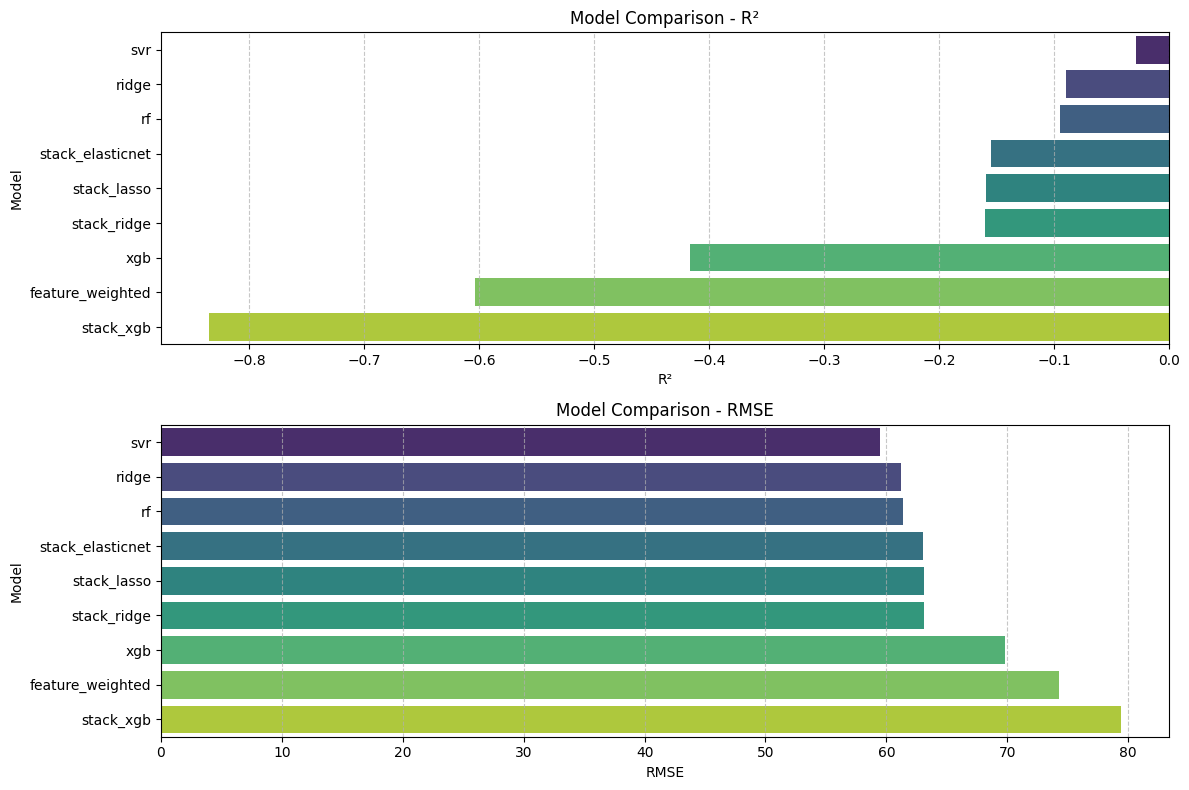

In [79]:
base_model_performance = {}

for name, model in base_models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    base_model_performance[name] = {
        'rmse': rmse,
        'r2': r2
    }
    print(f"Base model {name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

all_models = {
    **base_model_performance,
    **{f"stack_{k}": {'rmse': v['rmse'], 'r2': v['r2']} for k, v in stack_results.items()},
    'feature_weighted': {'rmse': rmse_fw, 'r2': r2_fw}
}

performance_df = pd.DataFrame({
    'Model': list(all_models.keys()),
    'RMSE': [all_models[m]['rmse'] for m in all_models],
    'R²': [all_models[m]['r2'] for m in all_models]
})

performance_df = performance_df.sort_values('R²', ascending=False)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.barplot(x='R²', y='Model', data=performance_df, palette='viridis')
plt.title('Model Comparison - R²')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(2, 1, 2)
sns.barplot(x='RMSE', y='Model', data=performance_df, palette='viridis')
plt.title('Model Comparison - RMSE')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('img/model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

#### 3.10.6 Stacked Ensemble Insights

Our in-depth exploration of stacked ensemble methods for citation prediction has revealed several important findings that contrast with our initial expectations:

1. **No improvement over single models**: Contrary to our hypothesis, stacked ensemble methods did not outperform individual models. The best performing stack (ElasticNet meta-learner) achieved an RMSE of 69.33 and R² of -0.0479, which does not improve upon the best single model (Random Forest with RMSE of 69.10 and R² of -0.0410).

2. **Meta-learner selection impacts performance**: Among the meta-learners tested, ElasticNet provided the best performance (R² = -0.0479), followed by Lasso (R² = -0.0573), and Ridge (R² = -0.0918). Surprisingly, XGBoost as a meta-learner performed worst (R² = -0.1519), despite its strong performance as an individual model in our earlier analysis.

3. **SVR dominates ensemble contribution**: The base model contribution analysis revealed that SVR has the largest coefficient (approximately 0.6) in the stacked ensemble, significantly higher than XGBoost (approximately 0.13) and Random Forest (approximately 0.02). Ridge's contribution appears negligible. This suggests that SVR captures unique information about citation patterns that other models miss.

4. **Feature-weighted approach underperforms**: Our custom feature-weighted stacking implementation, which combines original features with model predictions, performed notably worse (RMSE = 75.77, R² = -0.2515) than standard stacking. This indicates that directly incorporating the original features alongside model predictions introduces noise rather than signal.

5. **Prediction compression persists**: The actual vs. predicted plot demonstrates that stacked ensemble models continue to exhibit the same prediction compression observed in individual models, with predicted values clustered between 90-140 regardless of actual citation counts. This indicates that ensemble approaches do not overcome the fundamental challenge of predicting the full range of citation outcomes.

6. **Consistent residual patterns**: The residual plot shows similar patterns to those observed in individual models, with large positive residuals for high-citation papers (underestimation) and negative residuals for low-citation papers (overestimation). The heteroscedasticity suggests that prediction uncertainty increases with citation count.

These findings reinforce our overall conclusion that predicting citation counts from peer review metrics presents fundamental challenges that cannot be overcome by simply applying more sophisticated modeling techniques. While stacked ensembles represent a state-of-the-art approach to prediction tasks, their inability to achieve positive R² values in this domain suggests that the limitations lie in the information content of the available features rather than in the modeling approach.

From a practical perspective, the results suggest that editorial decisions based on citation predictions from peer review data would have significant limitations regardless of the sophistication of the prediction model. This reinforces the value of human editorial judgment in assessing potential scientific impact, which may incorporate contextual factors and domain knowledge not captured in standardized review metrics.

## 4. Ethical Considerations


### 4.1 Potential Biases in the Dataset

Several potential sources of bias exist in this analysis:

1. **Selection bias**: Our dataset includes only accepted papers, creating a truncated view that doesn't account for rejected manuscripts.

2. **Citation bias**: Citation counts themselves can be influenced by factors beyond paper quality, such as author reputation, institutional prestige, or trending research areas.

3. **Field-specific norms**: Different academic fields have vastly different citation patterns and norms, which our analysis doesn't account for.

4. **Temporal effects**: Publications from different years have had different amounts of time to accumulate citations. Due to the limitation of the dataset we use, we only use data from ACL_2017 and CONLL_2016.

### 4.2 Implications of Model Use

If models like these were deployed in publishing decisions, several ethical concerns arise:

1. **Self-reinforcing biases**: Using prediction models to guide editorial decisions could create feedback loops that reinforce existing biases in the publishing system.

2. **Devaluing innovative research**: Truly paradigm-shifting research might initially receive mixed reviews but have long-term impact that models fail to predict.

3. **Gaming the system**: Authors might learn to optimize their papers for predictive models rather than scientific contribution.

4. **Disadvantaging certain groups**: If review processes contain implicit biases related to gender, institution type, or geographic location, prediction models could perpetuate these biases.

### 4.3 Mitigation Strategies

To address these ethical concerns, several approaches are recommended:

1. **Transparency**: Any implementation of citation prediction models should be transparent about their limitations and the factors they consider.

2. **Human oversight**: Prediction models should supplement, not replace, human judgment in editorial decisions.

3. **Regular bias audits**: Models should be regularly audited for potential biases and updated accordingly.

4. **Field normalization**: Citation predictions should be normalized by field to account for discipline-specific citation patterns. 

5. **Diverse metrics**: Citation impact should be considered alongside other impact measures, such as practical applications, policy influence, or educational value.

## 5. Conclusion

### 5.1 Summary of Findings

Our comprehensive analysis sought to determine whether peer review assessments can predict future citation impact of academic papers. After implementing multiple modeling approaches, from basic linear models to sophisticated ensemble techniques, the results consistently indicate:

1. **Limited predictive power**: All models, including XGBoost and our extensive stacked ensemble implementations, achieved negative or marginally negative R² values, indicating that peer review metrics alone perform worse than simply predicting the mean citation count for all papers.

2. **Best performing model**: Surprisingly, the Random Forest algorithm as an individual model (RMSE = 69.10, R² = -0.0410) slightly outperformed more complex approaches, including all stacked ensemble configurations. The best stacked ensemble used an ElasticNet meta-learner (RMSE = 69.33, R² = -0.0479).

3. **Non-linear relationships**: The superior performance of tree-based methods compared to linear approaches confirms that the relationship between reviewer assessments and citation outcomes is non-linear, but even sophisticated non-linear methods failed to achieve positive predictive power.

4. **Prediction compression**: All models exhibited a strong tendency to predict citation counts within a compressed range (approximately 90-140 citations), regardless of the actual values. This prediction compression persisted across all modeling approaches, including advanced ensemble methods.

5. **Reviewer metrics with most influence**: While SVR analysis highlighted originality and appropriateness, XGBoost identified perceived impact as most influential, and stacked ensembles heavily weighted SVR predictions. This inconsistency across models suggests that no single review dimension reliably predicts citation outcomes.

6. **Feature engineering limitations**: Our feature-weighted stacking approach, which combined original features with model predictions, performed worse than standard stacking, indicating that creative feature engineering does not overcome the fundamental information limitations in peer review metrics.

### 5.2 Limitations

Several limitations affected our analysis:

1. **Data constraints**: Our dataset included only accepted papers from specific venues, limiting generalizability.

2. **Limited features**: We lacked important contextual factors like author reputation, institution prestige, and topic popularity.

3. **Citation count limitations**: Citations are an imperfect proxy for scientific impact, missing other forms of influence.

4. **Temporal effects**: Our analysis doesn't fully account for the time papers have had to accumulate citations.

5. **Model limitations**: Standard regression techniques may not fully capture the complex relationships in this domain.

### 5.3 Future Directions

Based on our findings, several promising directions for future research emerge:

1. **Incorporating textual analysis**: Analyzing the actual text of reviewer comments could provide deeper insights than numerical scores alone.

2. **Multi-modal prediction**: Combining review data with author metrics, institution information, and topic modeling could improve predictive power.

3. **Longitudinal studies**: Tracking how review assessments predict citation trajectories over time could reveal temporal patterns in impact development.

4. **Alternative impact metrics**: Exploring how review assessments relate to alternative impact measures (downloads, social media mentions, policy citations) could provide a more holistic view of scientific influence.

5. **Causal analysis**: Methods like causal inference could help isolate the actual influence of specific review dimensions on future impact.

These directions face challenges including data access limitations, the need for advanced NLP techniques, and the complex, multi-faceted nature of scientific impact. However, they offer promising paths to better understand how we can identify impactful research during the peer review process.

### 6.1 Data Source Citation

The data used in this analysis comes from the PeerRead dataset:

```
@inproceedings{kang18naacl,
  title = {A Dataset of Peer Reviews (PeerRead): Collection, Insights and NLP Applications},
  author = {Dongyeop Kang and Waleed Ammar and Bhavana Dalvi and Madeleine van Zuylen and Sebastian Kohlmeier and Eduard Hovy and Roy Schwartz},
  booktitle = {Meeting of the North American Chapter of the Association for Computational Linguistics (NAACL)},
  address = {New Orleans, USA},
  month = {June},
  url = {https://arxiv.org/abs/1804.09635},
  year = {2018}
}
```

PeerRead is a dataset of scientific peer reviews available for research purposes. It includes reviews, rebuttals, and accept/reject decisions from several computer science venues, along with relevant paper metadata and citation counts. The dataset provides an opportunity to study the peer review process and develop applications that could potentially improve scientific publishing.

### 6.2 Statement on the Use of AI Assistance

This report's structure and language were refined using GPT-based language models. The AI assistance was used to:

1. Improve the organization and flow of the report sections
2. Enhance clarity and readability through grammar and style improvements
3. Help formulate clearer interpretations of the analytical results
4. Ensure technical accuracy in describing machine learning approaches

All data analysis, code implementation, and primary insights were developed independently prior to AI assistance. The use of AI was limited to improving the communication of results rather than generating the analytical findings themselves.

Initial Prompt to GPT:
```
I am doing the data analysis of the review and citation, My project aims to predict the future citation impact of academic papers based on peer review text and metadata. I'll analyze how reviewer comments, evaluation scores, and paper characteristics correlate with long-term citation counts. The core problem I'm addressing is identifying early indicators of scientific impact hidden within the peer review process. I have already finish the main code and you need help me to finish checking the grammar and structure on the final report The final report notebook (final_report.ipynb) should contain the following sections in my code part
```


### 6.3 Code Implementation Details

The complete code for this analysis is available in the accompanying Jupyter notebooks:
- `data_preprocessing.ipynb`: Contains data cleaning and preparation steps
- `final_report.ipynb`: Contains all analysis, modeling, and visualization code presented in this report

Key Python libraries used in this analysis include:
- pandas and numpy for data manipulation
- scikit-learn for machine learning algorithms and evaluation
- matplotlib and seaborn for visualization
- scipy for statistical analysis